NN architecture:
 HarmonicNQS(
  (lc1): Linear(in_features=1, out_features=4, bias=True)
  (actfun): Sigmoid()
  (lc2): Linear(in_features=4, out_features=1, bias=False)
)


<IPython.core.display.Javascript object>


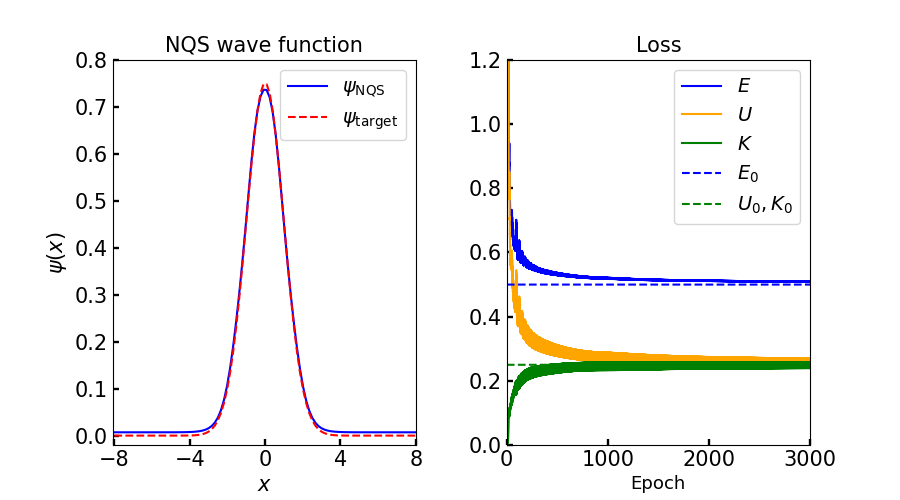

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 958.87it/s]


In [1]:
# Imports
import torch, time
from torch import nn, Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt # Plotting library
from tqdm import tqdm # Progress bar

# Hardware (CPU or GPU)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 4  # Nodes in the hidden layer

# Network parameters.
seed = 1
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients

# Training hyperparameters
epochs = 3000
lr = 2e-2  # Learning rate

# Mesh parameters
n_samples = 100                    # Mesh division
train_a = -8                      # Mesh lower limit
train_b = 8                        # Mesh upper limit
h = (train_b - train_a)/(n_samples - 1)  # Mesh parameter "h"
Q_train = torch.linspace(train_a, train_b, n_samples, 
                         requires_grad=True, 
                         device=device)  

target = (1/np.pi)**(1/4) * torch.exp(-Q_train.pow(2)/2).to(device)

class HarmonicNQS(nn.Module):
    def __init__(self, W1, B, W2):
        super(HarmonicNQS, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=False)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o
    
net = HarmonicNQS(W1, B, W2).to(device)
print("NN architecture:\n", net)

optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

def loss_fn():  
    psi = net(X)    
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = h * psi2.sum()                       
    U = h * (1/2) * (X.clone().detach().pow(2) * psi2).sum() / N  
    K = h * (1/2) * dpsi_dx.pow(2).sum() / N              
    E = U + K   
    
    return E, U, K, psi, psi / torch.sqrt(N) 

def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax3):   
    
    # Overlap
    ax1.set_title('NQS wave function', fontsize=15)
    wf = psi_normalized.detach().numpy()
    maxwf = np.max(wf)
    if maxwf < 0: wf = -wf
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x.detach().numpy())
        ax1.lines[1].set_ydata(target.detach().numpy())
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(x.detach().numpy(), target.detach().numpy(), linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend(fontsize=14)

    # Loss
    ax3.set_title("Loss", fontsize=15)
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)-0.5, np.ones(i+1)-0.75][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)-0.5, linestyle='--', label='$E_0$', color='b')
        ax3.plot(x, np.ones(i+1)-0.75, linestyle='--', label='$U_0, K_0$', color='g')
        ax3.legend(fontsize=14)
        
    fig.canvas.draw()
    
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
ax1, ax3 = ax[0], ax[1]
plt.subplots_adjust(wspace=0.3)

# Overlap
ax1.set_xlim(-8.1, 8)
ax1.set_ylim(-0.02, 0.8)
ax1.set_xlabel("$x$", fontsize=15)
ax1.set_ylabel("$\psi(x)$", fontsize=15)
ax1.set_xticks(np.arange(-8, 8.01, step=4))
ax1.tick_params(axis='both', labelsize=15)
ax1.tick_params(axis='both', which='both', direction='in')
ax1.tick_params(axis='both', which='major', width=1.7, length=4.5)

# Loss
ax3.set_xlabel("Epoch", fontsize=13)
ax3.tick_params(axis='both', labelsize=15)
ax3.tick_params(axis='both', which='both', direction='in')
ax3.tick_params(axis='both', which='major', width=1.7, length=4.5)
ax3.set_ylim(0, 1.2)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss0, U, K, psi, psi_normalized = loss_fn()    # Energy and \psi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss0.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss_accum.append(loss0.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 500 == 0): # We plot periodically
        pic(i, Q_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax3)
        time.sleep(0.1)

E0, psi0 = loss_accum[-1], psi.clone().detach()
plt.savefig('HO_training.pdf', format='pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


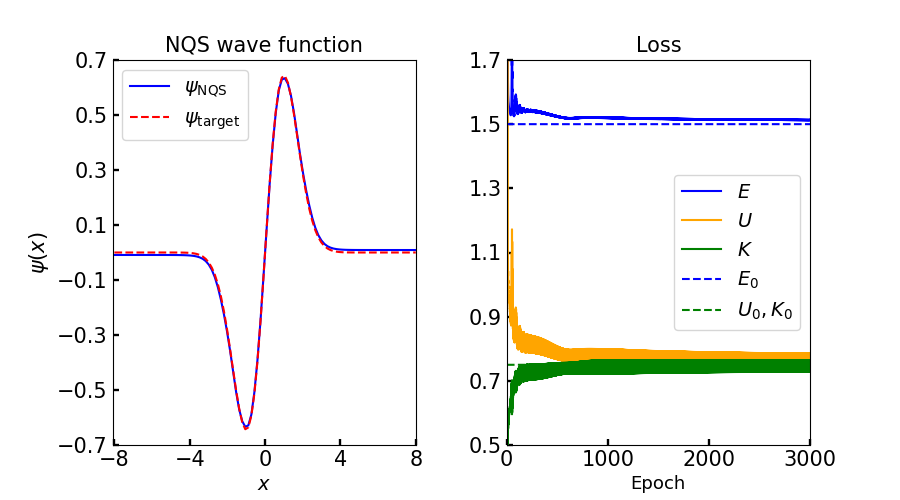

Training the NQS...: 100%|███████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 813.57it/s]


In [2]:
def loss_fn_prime(E0, psi0):  
    psi = net1(X)-net1(-X)    
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    # Energy term
    N = h * psi2.sum()                       
    U = h * (1/2) * (X.pow(2) * psi2).sum() / N  
    K = h * (1/2) * dpsi_dx.pow(2).sum() / N              
    E = U + K   

    # Total loss
    L = E
    
    return L, U, K, psi, psi / torch.sqrt(N) 

net1 = HarmonicNQS(W1, B, W2).to(device)
optimizer = torch.optim.RMSprop(params=net1.parameters(), lr=lr)

target = (2 / np.sqrt(2))*(np.power(np.pi, -1/4))*torch.exp(-Q_train.pow(2) / 2)*Q_train

def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax3):   
    
    # Overlap
    ax1.set_title('NQS wave function', fontsize=15)
    wf = psi_normalized.detach().numpy()
    maxwf = np.max(wf)
    if maxwf < 0: wf = -wf
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x.detach().numpy())
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x.detach().numpy())
        ax1.lines[1].set_ydata(target.detach().numpy())
    else:
        # This code will only run the first time the function is called
        ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NQS}$', color='b')
        ax1.plot(x.detach().numpy(), target.detach().numpy(), linestyle="--", 
                 label='$\psi_\mathrm{target}$', color='r')
        ax1.legend(fontsize=14)

    # Loss
    ax3.set_title("Loss", fontsize=15)
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [loss, U, K, np.ones(i+1)+0.5, np.ones(i+1)-0.25][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, U, label='$U$', color='orange')
        ax3.plot(x, K, label='$K$', color='g')
        ax3.plot(x, np.ones(i+1)+0.5, linestyle='--', label='$E_0$', color='b')
        ax3.plot(x, np.ones(i+1)-0.25, linestyle='--', label='$U_0, K_0$', color='g')
        ax3.legend(fontsize=14)
        
    fig.canvas.draw()
    
# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
ax1, ax3 = ax[0], ax[1]
plt.subplots_adjust(wspace=0.3)

# Overlap
ax1.set_xlim(-8.1, 8)
ax1.set_ylim(-0.7, 0.7)
ax1.set_yticks(np.arange(-0.7, 0.71, step=0.2))
ax1.set_xticks(np.arange(-8, 8.01, step=4))
ax1.set_xlabel("$x$", fontsize=14)
ax1.set_ylabel("$\psi(x)$", fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
ax1.tick_params(axis='both', which='both', direction='in')
ax1.tick_params(axis='both', which='major', width=1.7, length=4.5)

# Loss
ax3.set_yticks(np.arange(0.5, 1.71, step=0.2))
ax3.set_xlabel("Epoch", fontsize=13)
ax3.tick_params(axis='both', labelsize=15)
ax3.tick_params(axis='both', which='both', direction='in')
ax3.tick_params(axis='both', which='major', width=1.7, length=4.5)
ax3.set_ylim(0.5, 1.7)

loss_accum = []
U_accum = []
K_accum = []
X = Q_train.clone().unsqueeze(1)

# Training
for i in tqdm(range(epochs), desc="Training the NQS..."):
    loss1, U, K, psi, psi_normalized = loss_fn_prime(E0, psi0)    # Energy and \psi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss1.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss_accum.append(loss1.item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 500 == 0): # We plot periodically
        pic(i, Q_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax3)
        time.sleep(0.1)
        
E1, psi1 = loss_accum[-1], psi
plt.savefig('HO_training_excited.pdf', format='pdf', bbox_inches='tight')